<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/Dtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def gini_impurity(y):

    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)


In [2]:
def information_gain(y_parent, y_left, y_right):

    impurity_parent = gini_impurity(y_parent)
    n = len(y_parent)
    n_left = len(y_left)
    n_right = len(y_right)

    weighted_impurity = (n_left / n) * gini_impurity(y_left) + (n_right / n) * gini_impurity(y_right)
    return impurity_parent - weighted_impurity


In [3]:
class ScratchDecesionTreeClassifierDepth1():
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None

    def fit(self, X, y):
        best_gain = -1
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left_idx = X[:, feature] <= thresh
                right_idx = X[:, feature] > thresh
                y_left, y_right = y[left_idx], y[right_idx]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature, thresh, y_left, y_right)

        self.feature_index, self.threshold, y_left, y_right = best_split
        self.left_class = self._majority_class(y_left)
        self.right_class = self._majority_class(y_right)

        if self.verbose:
            print(f"Best split: Feature {self.feature_index}, Threshold {self.threshold}, Info Gain {best_gain:.3f}")

    def _majority_class(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        predictions = []
        for x in X:
            if x[self.feature_index] <= self.threshold:
                predictions.append(self.left_class)
            else:
                predictions.append(self.right_class)
        return np.array(predictions)


In [4]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = ScratchDecesionTreeClassifierDepth1(verbose=True)
model.fit(X, y)
y_pred = model.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))


Best split: Feature 0, Threshold 0.15513175371110188, Info Gain 0.424
Accuracy: 0.96


In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()




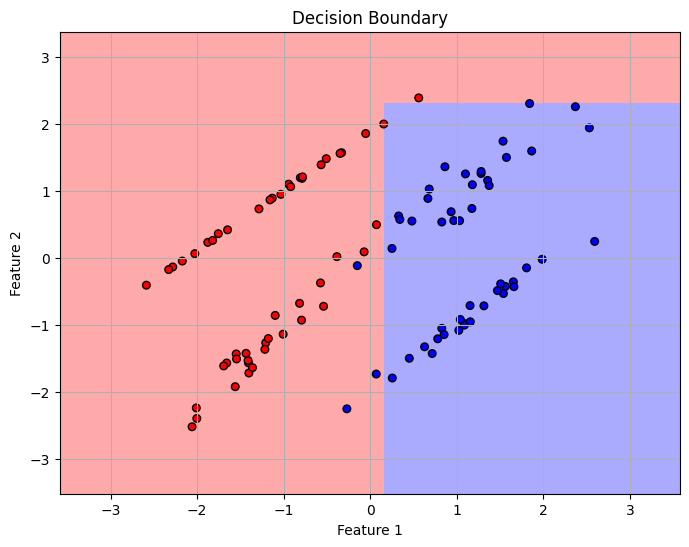

In [12]:
plot_decision_boundary(model, X, y)

In [6]:
class Node:
    def __init__(self, depth=0, max_depth=2):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.class_label = None

    def is_leaf(self):
        return self.class_label is not None


In [10]:
class ScratchDecisionTreeClassifierDepth2:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        node = Node(depth=depth)
        if depth >= node.max_depth or gini_impurity(y) == 0:
            node.class_label = np.bincount(y).argmax()
            return node

        best_gain = -1
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left_idx = X[:, feature] <= thresh
                right_idx = X[:, feature] > thresh
                y_left, y_right = y[left_idx], y[right_idx]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature, thresh, X[left_idx], y_left, X[right_idx], y_right)

        if best_split is None:
            node.class_label = np.bincount(y).argmax()
            return node

        feature, thresh, X_left, y_left, X_right, y_right = best_split
        node.feature_index = feature
        node.threshold = thresh
        node.left = self._build_tree(X_left, y_left, depth + 1)
        node.right = self._build_tree(X_right, y_right, depth + 1)

        if self.verbose:
            print(f"Depth {depth}: Split on feature {feature} at threshold {thresh}, Info Gain {best_gain:.3f}")

        return node

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

    def _predict_sample(self, x, node):
        while not node.is_leaf():
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.class_label

Depth 1: Split on feature 0 at threshold -0.33137609720725414, Info Gain 0.043
Depth 1: Split on feature 1 at threshold 2.3045001941840453, Info Gain 0.041
Depth 0: Split on feature 0 at threshold 0.15513175371110188, Info Gain 0.424
Accuracy: 0.97


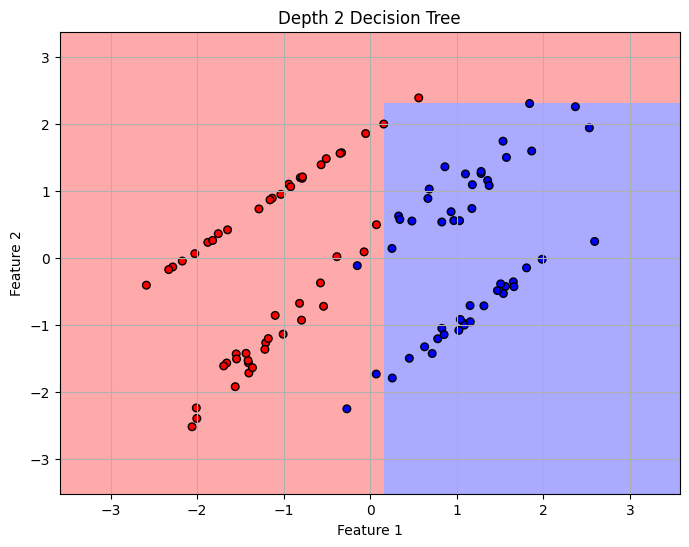

In [11]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = ScratchDecisionTreeClassifierDepth2(verbose=True)
model.fit(X, y)
y_pred = model.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))
plot_decision_boundary(model, X, y, title="Depth 2 Decision Tree")
